In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

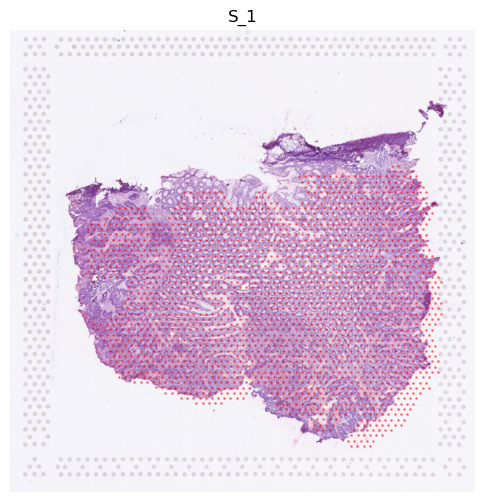

In [2]:
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

# Ad binary in Train dataset

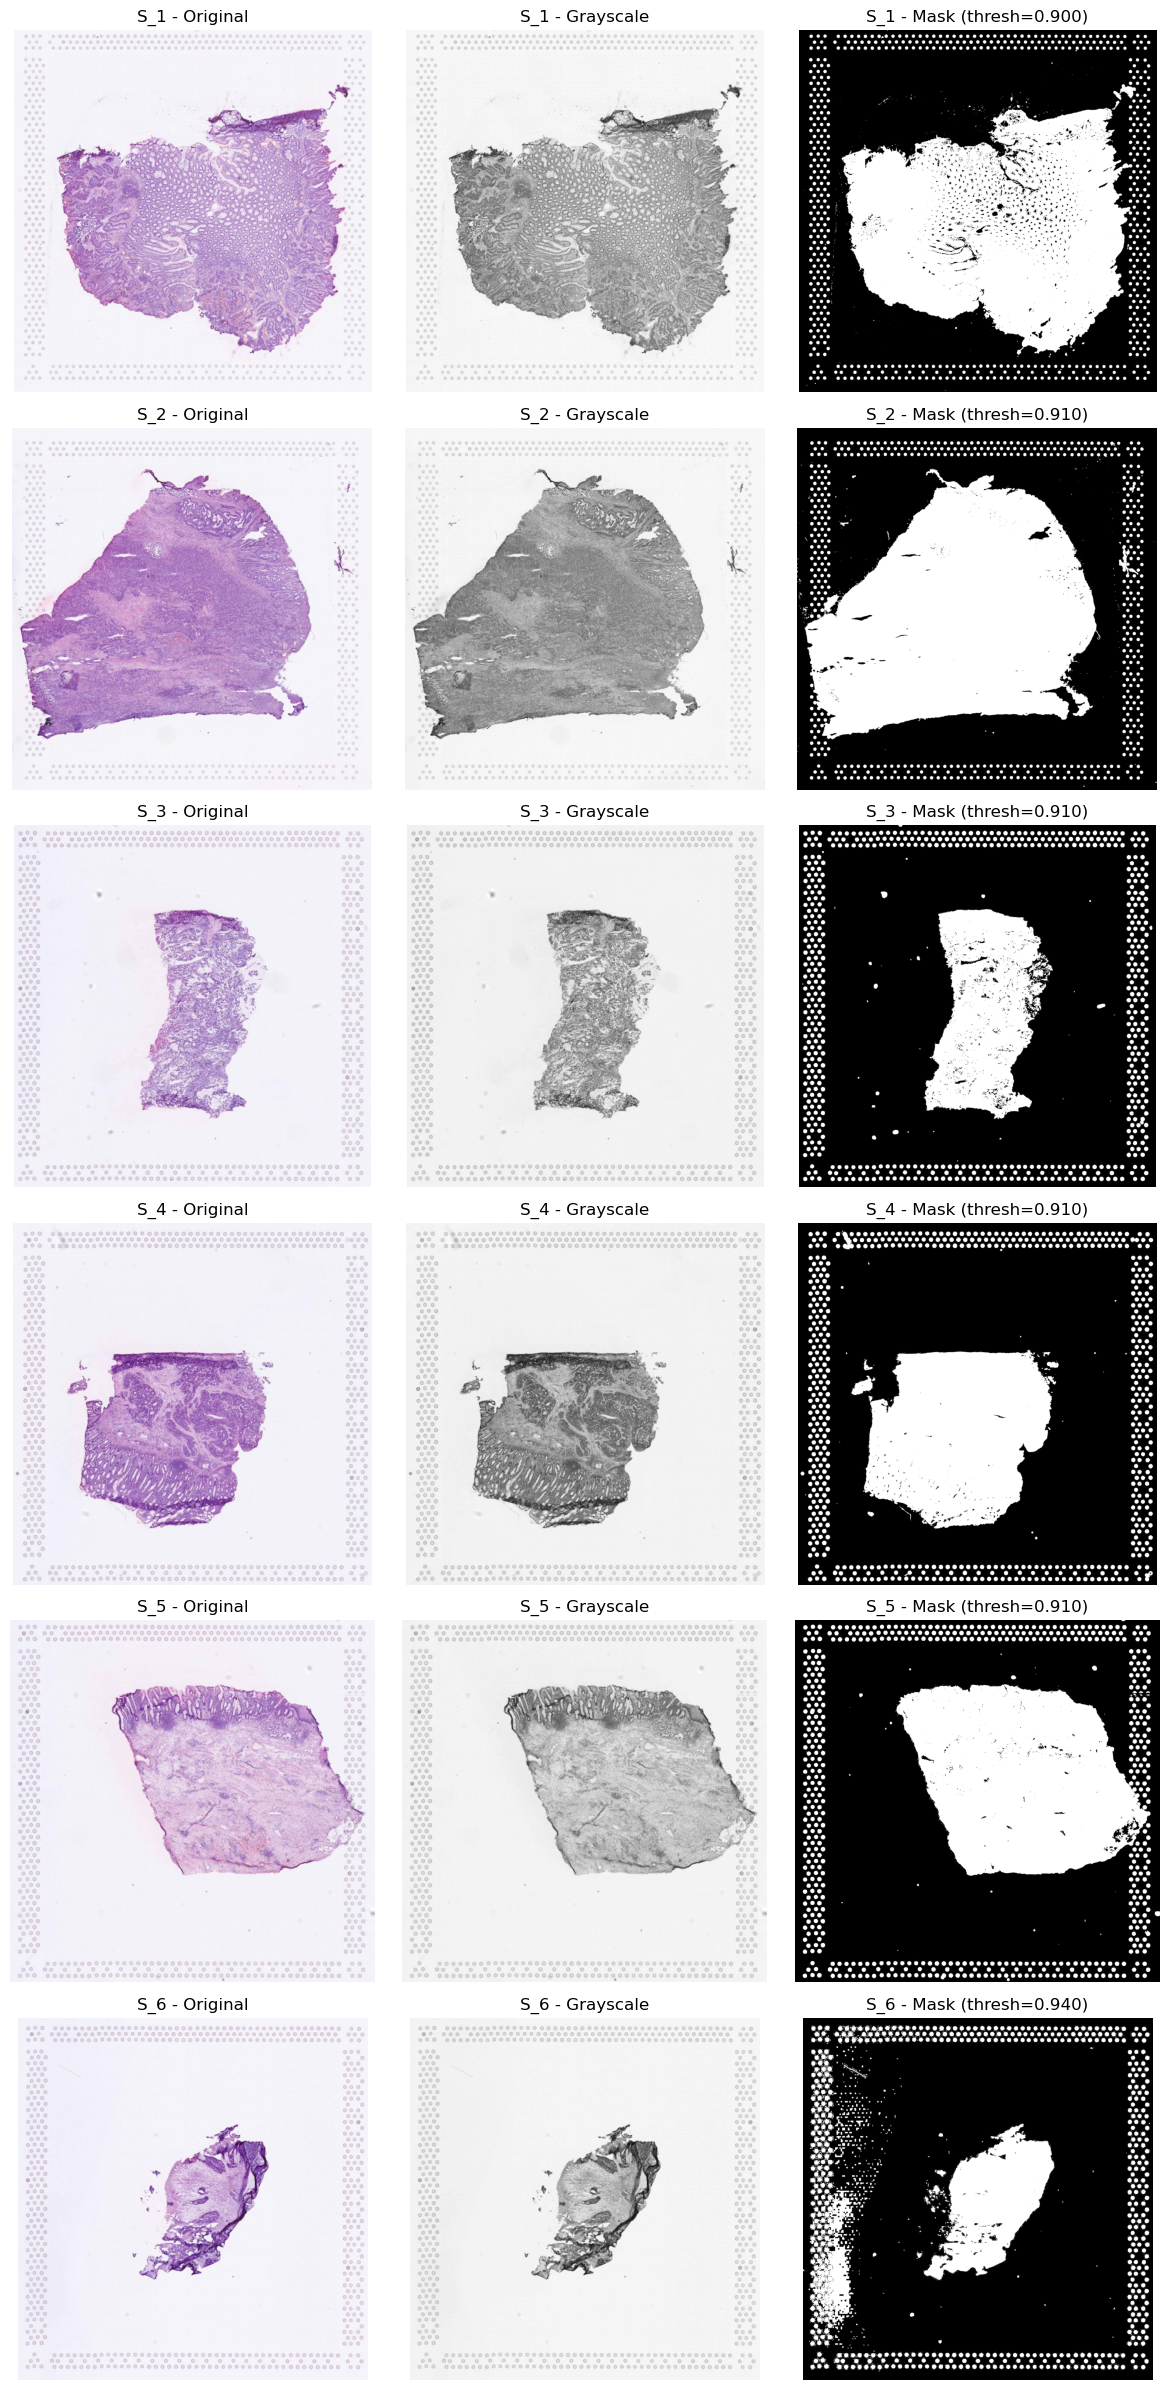

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
custom_thresholds = {
    "S_1": 0.90,
    "S_2": 0.91,
    "S_3": 0.91,
    "S_4": 0.91,
    "S_5": 0.91,
    "S_6": 0.94,
}
slide_masks = {}
slide_thresholds = {}
slide ={}
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_images.keys())

    n = len(slide_ids)
    fig, axs = plt.subplots(nrows=n, ncols=3, figsize=(12, 4 * n))
    if n == 1:
        axs = [axs]

    for i, slide_id in enumerate(slide_ids):
        image = np.array(train_images[slide_id])
        gray_image = rgb2gray(image)

        # ✅ 使用自訂 threshold（如果沒有就 fallback）
        thresh = custom_thresholds.get(slide_id, threshold_mean(gray_image))
        binary_mask = (gray_image > thresh).astype(np.uint8)
        binary_mask = 1 - binary_mask

        slide[slide_id] = image
        slide_masks[slide_id] = binary_mask
        slide_thresholds[slide_id] = thresh

        axs[i][0].imshow(image)
        axs[i][0].set_title(f"{slide_id} - Original")
        axs[i][0].axis("off")

        axs[i][1].imshow(gray_image, cmap="gray")
        axs[i][1].set_title(f"{slide_id} - Grayscale")
        axs[i][1].axis("off")

        axs[i][2].imshow(binary_mask, cmap="gray")
        axs[i][2].set_title(f"{slide_id} - Mask (thresh={thresh:.3f})")
        axs[i][2].axis("off")

    plt.tight_layout()
    plt.show()



In [4]:
import h5py
import numpy as np

# slide_masks 假設已經存在，是一個 dict：slide_id -> binary mask (np.array)
new_slide_masks = {}
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_images.keys())

    for slide_id in slide_ids:
        image = np.array(train_images[slide_id])  # shape: (H, W, 3)
        mask = slide_masks[slide_id].copy()  # ✅ 獨立副本

        # 👉 建立一個 image-level mask，判斷哪些 pixel 全部通道為 0
        image_zero_mask = np.all(image == 0, axis=-1)  # shape: (H, W), bool

        # ✅ 將 slide_mask 中那些對應 0 的地方也設為 0
        mask[image_zero_mask] = 0
        new_slide_masks[slide_id] = mask  # 更新回去（其實不用這行，原本就是 mutable）

        print(f"✔️ {slide_id} 已同步處理，0 區塊從 image -> mask 傳遞完成。")


✔️ S_1 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_2 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_3 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_4 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_5 已同步處理，0 區塊從 image -> mask 傳遞完成。
✔️ S_6 已同步處理，0 區塊從 image -> mask 傳遞完成。


Text(0.5, 1.0, 'Mask After Aligning with Image Zero')

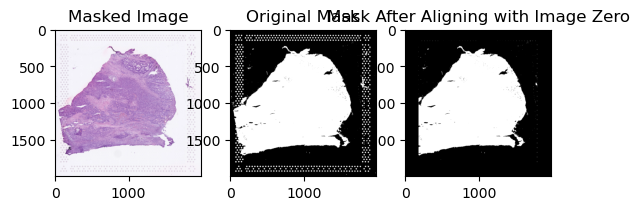

In [7]:
slide_id = 'S_2'
plt.subplot(1, 3, 1)
plt.imshow(slide[slide_id])
plt.title("Masked Image")

plt.subplot(1, 3, 2)
plt.imshow(slide_masks[slide_id] , cmap="gray")
plt.title("Original Mask")

plt.subplot(1, 3, 3)
plt.imshow(new_slide_masks[slide_id], cmap="gray")
plt.title("Mask After Aligning with Image Zero")


In [6]:
print(slide[slide_id].shape)

(2000, 1974, 3)


In [7]:
combined_slide_images = {}  # slide_id -> (H, W, 4)

for slide_id in slide.keys():
    image = slide[slide_id]                  # shape: (H, W, 3)
    mask = new_slide_masks[slide_id]         # shape: (H, W)

    # ✅ 先把 mask 加一個通道軸，變成 (H, W, 1)
    mask = np.expand_dims(mask, axis=-1)

    # ✅ 合併成 (H, W, 4)
    combined = np.concatenate([image, mask], axis=-1)  # 如果想讓 mask 是 0/255 表示可視化

    combined_slide_images[slide_id] = combined
    print(f"✔️ 合併完成: {slide_id} → shape {combined.shape}")


✔️ 合併完成: S_1 → shape (2000, 1974, 4)
✔️ 合併完成: S_2 → shape (2000, 1988, 4)
✔️ 合併完成: S_3 → shape (2000, 1966, 4)
✔️ 合併完成: S_4 → shape (2000, 1979, 4)
✔️ 合併完成: S_5 → shape (1985, 2000, 4)
✔️ 合併完成: S_6 → shape (2000, 1930, 4)


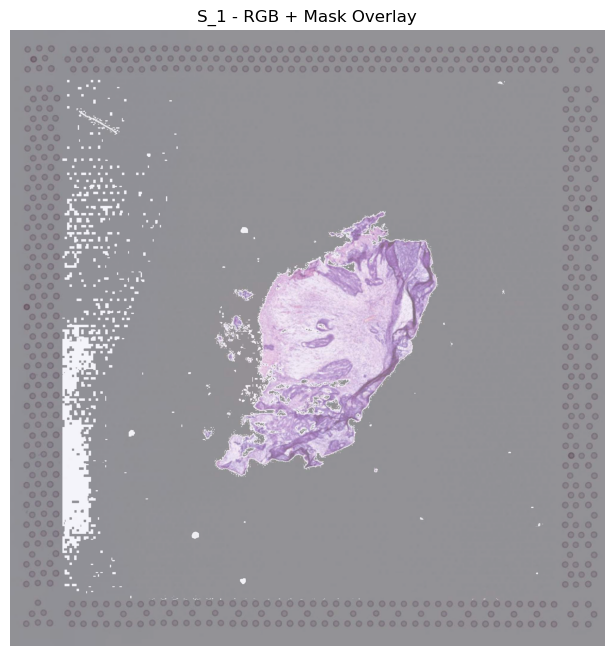

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(combined_slide_images['S_6'][:, :, :3])  # RGB
plt.imshow(combined_slide_images['S_6'][:, :, 3], cmap='gray', alpha=0.4)  # Mask 疊加
plt.title("S_1 - RGB + Mask Overlay")
plt.axis('off')
plt.show()


In [363]:
import h5py
import numpy as np

output_path = "./dataset/combined_slide_images_with_mask.h5"

with h5py.File(output_path, "w") as f:
    image_group = f.create_group("images/Train")

    for slide_id, combined_img in combined_slide_images.items():
        image_group.create_dataset(slide_id, data=combined_img)
        print(f"✔️ 已儲存 {slide_id} → shape {combined_img.shape}")

print(f"\n✅ 所有圖像+mask 已儲存到：{output_path}")


✔️ 已儲存 S_1 → shape (2000, 1974, 4)
✔️ 已儲存 S_2 → shape (2000, 1988, 4)
✔️ 已儲存 S_3 → shape (2000, 1966, 4)
✔️ 已儲存 S_4 → shape (2000, 1979, 4)
✔️ 已儲存 S_5 → shape (1985, 2000, 4)
✔️ 已儲存 S_6 → shape (2000, 1930, 4)

✅ 所有圖像+mask 已儲存到：./dataset/combined_slide_images_with_mask.h5


# Ad binary in Test dataset

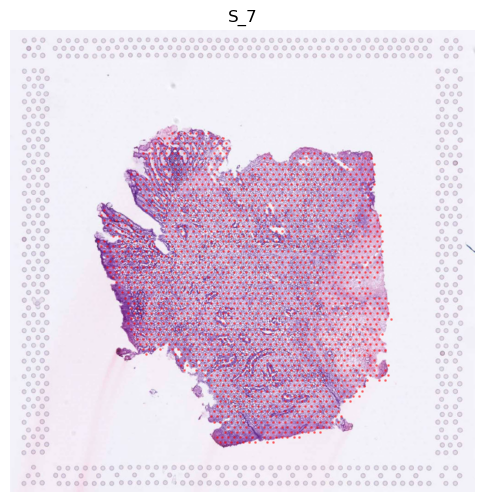

In [7]:
# Visualize Test slide ('S_7')
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    test_spots = h5file["spots/Test"]
    
    sample = 'S_7'
    image = np.array(test_images[sample])
    spots = np.array(test_spots[sample])
    x, y = spots["x"], spots["y"]

    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

0.8490186


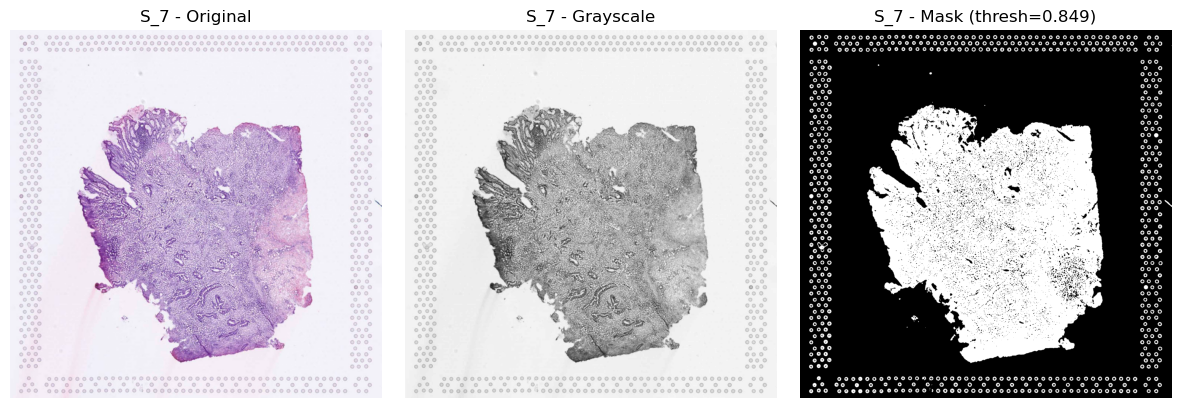

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
custom_thresholds = {
    
}
slide_masks = {}
slide_thresholds = {}
slide ={}
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Test"]
    slide_ids = list(train_images.keys())

    n = len(slide_ids)
    fig, axs = plt.subplots(nrows=n, ncols=3, figsize=(12, 4 * n))
    if n == 1:
        axs = [axs]

    for i, slide_id in enumerate(slide_ids):
        image = np.array(train_images[slide_id])
        gray_image = rgb2gray(image)

        # ✅ 使用自訂 threshold（如果沒有就 fallback）
        thresh = custom_thresholds.get(slide_id, threshold_mean(gray_image))
        binary_mask = (gray_image > thresh).astype(np.uint8)
        binary_mask = 1 - binary_mask
        print(thresh)
        slide[slide_id] = image
        slide_masks[slide_id] = binary_mask
        slide_thresholds[slide_id] = thresh

        axs[i][0].imshow(image)
        axs[i][0].set_title(f"{slide_id} - Original")
        axs[i][0].axis("off")

        axs[i][1].imshow(gray_image, cmap="gray")
        axs[i][1].set_title(f"{slide_id} - Grayscale")
        axs[i][1].axis("off")

        axs[i][2].imshow(binary_mask, cmap="gray")
        axs[i][2].set_title(f"{slide_id} - Mask (thresh={thresh:.3f})")
        axs[i][2].axis("off")

    plt.tight_layout()
    plt.show()



✔️ 合併完成: S_7 → shape (1983, 2000, 4)


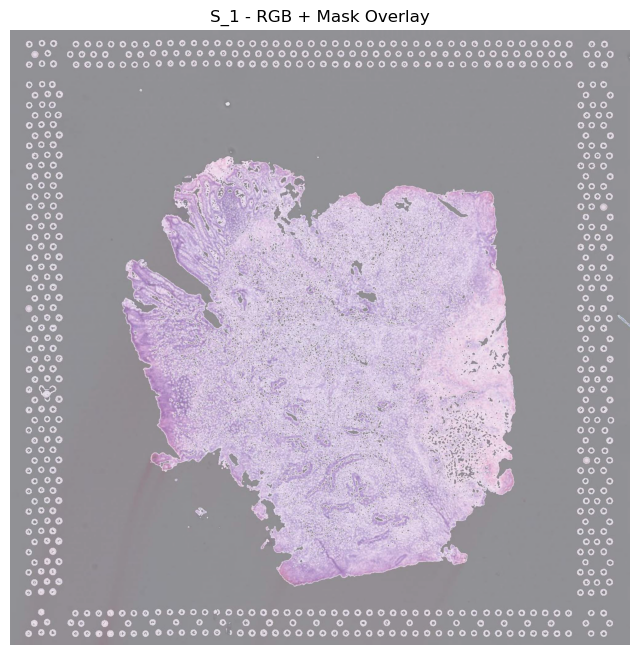

In [16]:
combined_slide_images = {}  # slide_id -> (H, W, 4)

for slide_id in slide.keys():
    image = slide[slide_id]                  # shape: (H, W, 3)
    mask = slide_masks[slide_id]         # shape: (H, W)

    # ✅ 先把 mask 加一個通道軸，變成 (H, W, 1)
    mask = np.expand_dims(mask, axis=-1)

    # ✅ 合併成 (H, W, 4)
    combined = np.concatenate([image, mask], axis=-1)  # 如果想讓 mask 是 0/255 表示可視化

    combined_slide_images[slide_id] = combined
    print(f"✔️ 合併完成: {slide_id} → shape {combined.shape}")
plt.figure(figsize=(8, 8))
plt.imshow(combined_slide_images['S_7'][:, :, :3])  # RGB
plt.imshow(combined_slide_images['S_7'][:, :, 3], cmap='gray', alpha=0.4)  # Mask 疊加
plt.title("S_1 - RGB + Mask Overlay")
plt.axis('off')
plt.show()


In [17]:
import h5py
import numpy as np

output_path = "./dataset/combined_slide_images_with_mask_test.h5"

with h5py.File(output_path, "w") as f:
    image_group = f.create_group("images/Test")

    for slide_id, combined_img in combined_slide_images.items():
        image_group.create_dataset(slide_id, data=combined_img)
        print(f"✔️ 已儲存 {slide_id} → shape {combined_img.shape}")

print(f"\n✅ 所有圖像+mask 已儲存到：{output_path}")


✔️ 已儲存 S_7 → shape (1983, 2000, 4)

✅ 所有圖像+mask 已儲存到：./dataset/combined_slide_images_with_mask_test.h5
